In [1]:
!pip install caer canaro

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.5/809.5 kB 42.2 MB/s eta 0:00:00
  Obtaining dependency information for mypy from https://files.pythonhosted.org/packages/f1/48/e78aa47176bf7c24beb321031043d7c9c99035d816a6eca32d13cc59736f/mypy-1.8.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 80.9 MB/s eta 0:00:00:00:0100:01


# Exploring Deep Learning with CNN for Simpsons


### Introduction
In the vast realm of computer vision, image classification stands as a fundamental task, powering a myriad of applications from facial recognition to autonomous vehicles. This project delves into the exciting domain of image classification using state-of-the-art Convolutional Neural Networks (CNNs), with the goal of accurately categorizing images among ten distinct classes.

In [62]:
# Call Library
import os 
import caer
import canaro
import numpy as np
import matplotlib.pyplot as plp
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import SGD
import cv2 as cv
import gc
import re

In [3]:
# Must all Imge hase seme shape
IMG_SIZE = (80,80)
channels = 1
char_path = r'/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset'

## Image Preprocessing: Crafting a Feature-Rich Dataset for Deep Learning in Image Classification

In [4]:
# /kaggle/input/the-simpsons-characters-dataset/simpsons_dataset/char[0],char[1]
char_dict = {}
for char in os.listdir(char_path):
    char_dict[char] = len(os.listdir(os.path.join(char_path,char)))

# Sort in descending order 
char_dict = caer.sort_dict(char_dict, descending=True)
char_dict

[('homer_simpson', 2246),
 ('ned_flanders', 1454),
 ('moe_szyslak', 1452),
 ('lisa_simpson', 1354),
 ('bart_simpson', 1342),
 ('marge_simpson', 1291),
 ('krusty_the_clown', 1206),
 ('principal_skinner', 1194),
 ('charles_montgomery_burns', 1193),
 ('milhouse_van_houten', 1079),
 ('chief_wiggum', 986),
 ('abraham_grampa_simpson', 913),
 ('sideshow_bob', 877),
 ('apu_nahasapeemapetilon', 623),
 ('kent_brockman', 498),
 ('comic_book_guy', 469),
 ('edna_krabappel', 457),
 ('nelson_muntz', 358),
 ('lenny_leonard', 310),
 ('mayor_quimby', 246),
 ('waylon_smithers', 181),
 ('maggie_simpson', 128),
 ('groundskeeper_willie', 121),
 ('barney_gumble', 106),
 ('selma_bouvier', 103),
 ('carl_carlson', 98),
 ('ralph_wiggum', 89),
 ('patty_bouvier', 72),
 ('martin_prince', 71),
 ('professor_john_frink', 65),
 ('snake_jailbird', 55),
 ('cletus_spuckler', 47),
 ('rainier_wolfcastle', 45),
 ('simpsons_dataset', 42),
 ('agnes_skinner', 42),
 ('sideshow_mel', 40),
 ('otto_mann', 32),
 ('fat_tony', 27),
 (

In [5]:
characters = []
count = 0
for i in char_dict:
    characters.append(i[0])
    count += 1
    if count >= 10:
        break

characters

['homer_simpson',
 'ned_flanders',
 'moe_szyslak',
 'lisa_simpson',
 'bart_simpson',
 'marge_simpson',
 'krusty_the_clown',
 'principal_skinner',
 'charles_montgomery_burns',
 'milhouse_van_houten']

In [6]:
# Create the training data
train = caer.preprocess_from_dir(char_path, characters, channels=channels,
                                 IMG_SIZE=IMG_SIZE, isShuffle=True)

[INFO] Could not find a file to load from. Generating the training data
----------------------------------------------
[INFO] At 1000 files
[INFO] At 2000 files
[INFO] 2246 files found in 1.2816877365112305s
[INFO] At 1000 files
[INFO] 1454 files found in 0.37953853607177734s
[INFO] At 1000 files
[INFO] 1452 files found in 0.3411369323730469s
[INFO] At 1000 files
[INFO] 1354 files found in 0.21253132820129395s
[INFO] At 1000 files
[INFO] 1342 files found in 0.2267293930053711s
[INFO] At 1000 files
[INFO] 1291 files found in 0.1878197193145752s
[INFO] At 1000 files
[INFO] 1206 files found in 0.0805361270904541s
[INFO] At 1000 files
[INFO] 1194 files found in 0.061942100524902344s
[INFO] At 1000 files
[INFO] 1193 files found in 0.0692598819732666s
[INFO] At 1000 files
[INFO] 1079 files found in 0.004422903060913086s
----------------------------------------------
[INFO] 13811 files preprocessed! Took 1m 32s


In [7]:
len(train)

13811

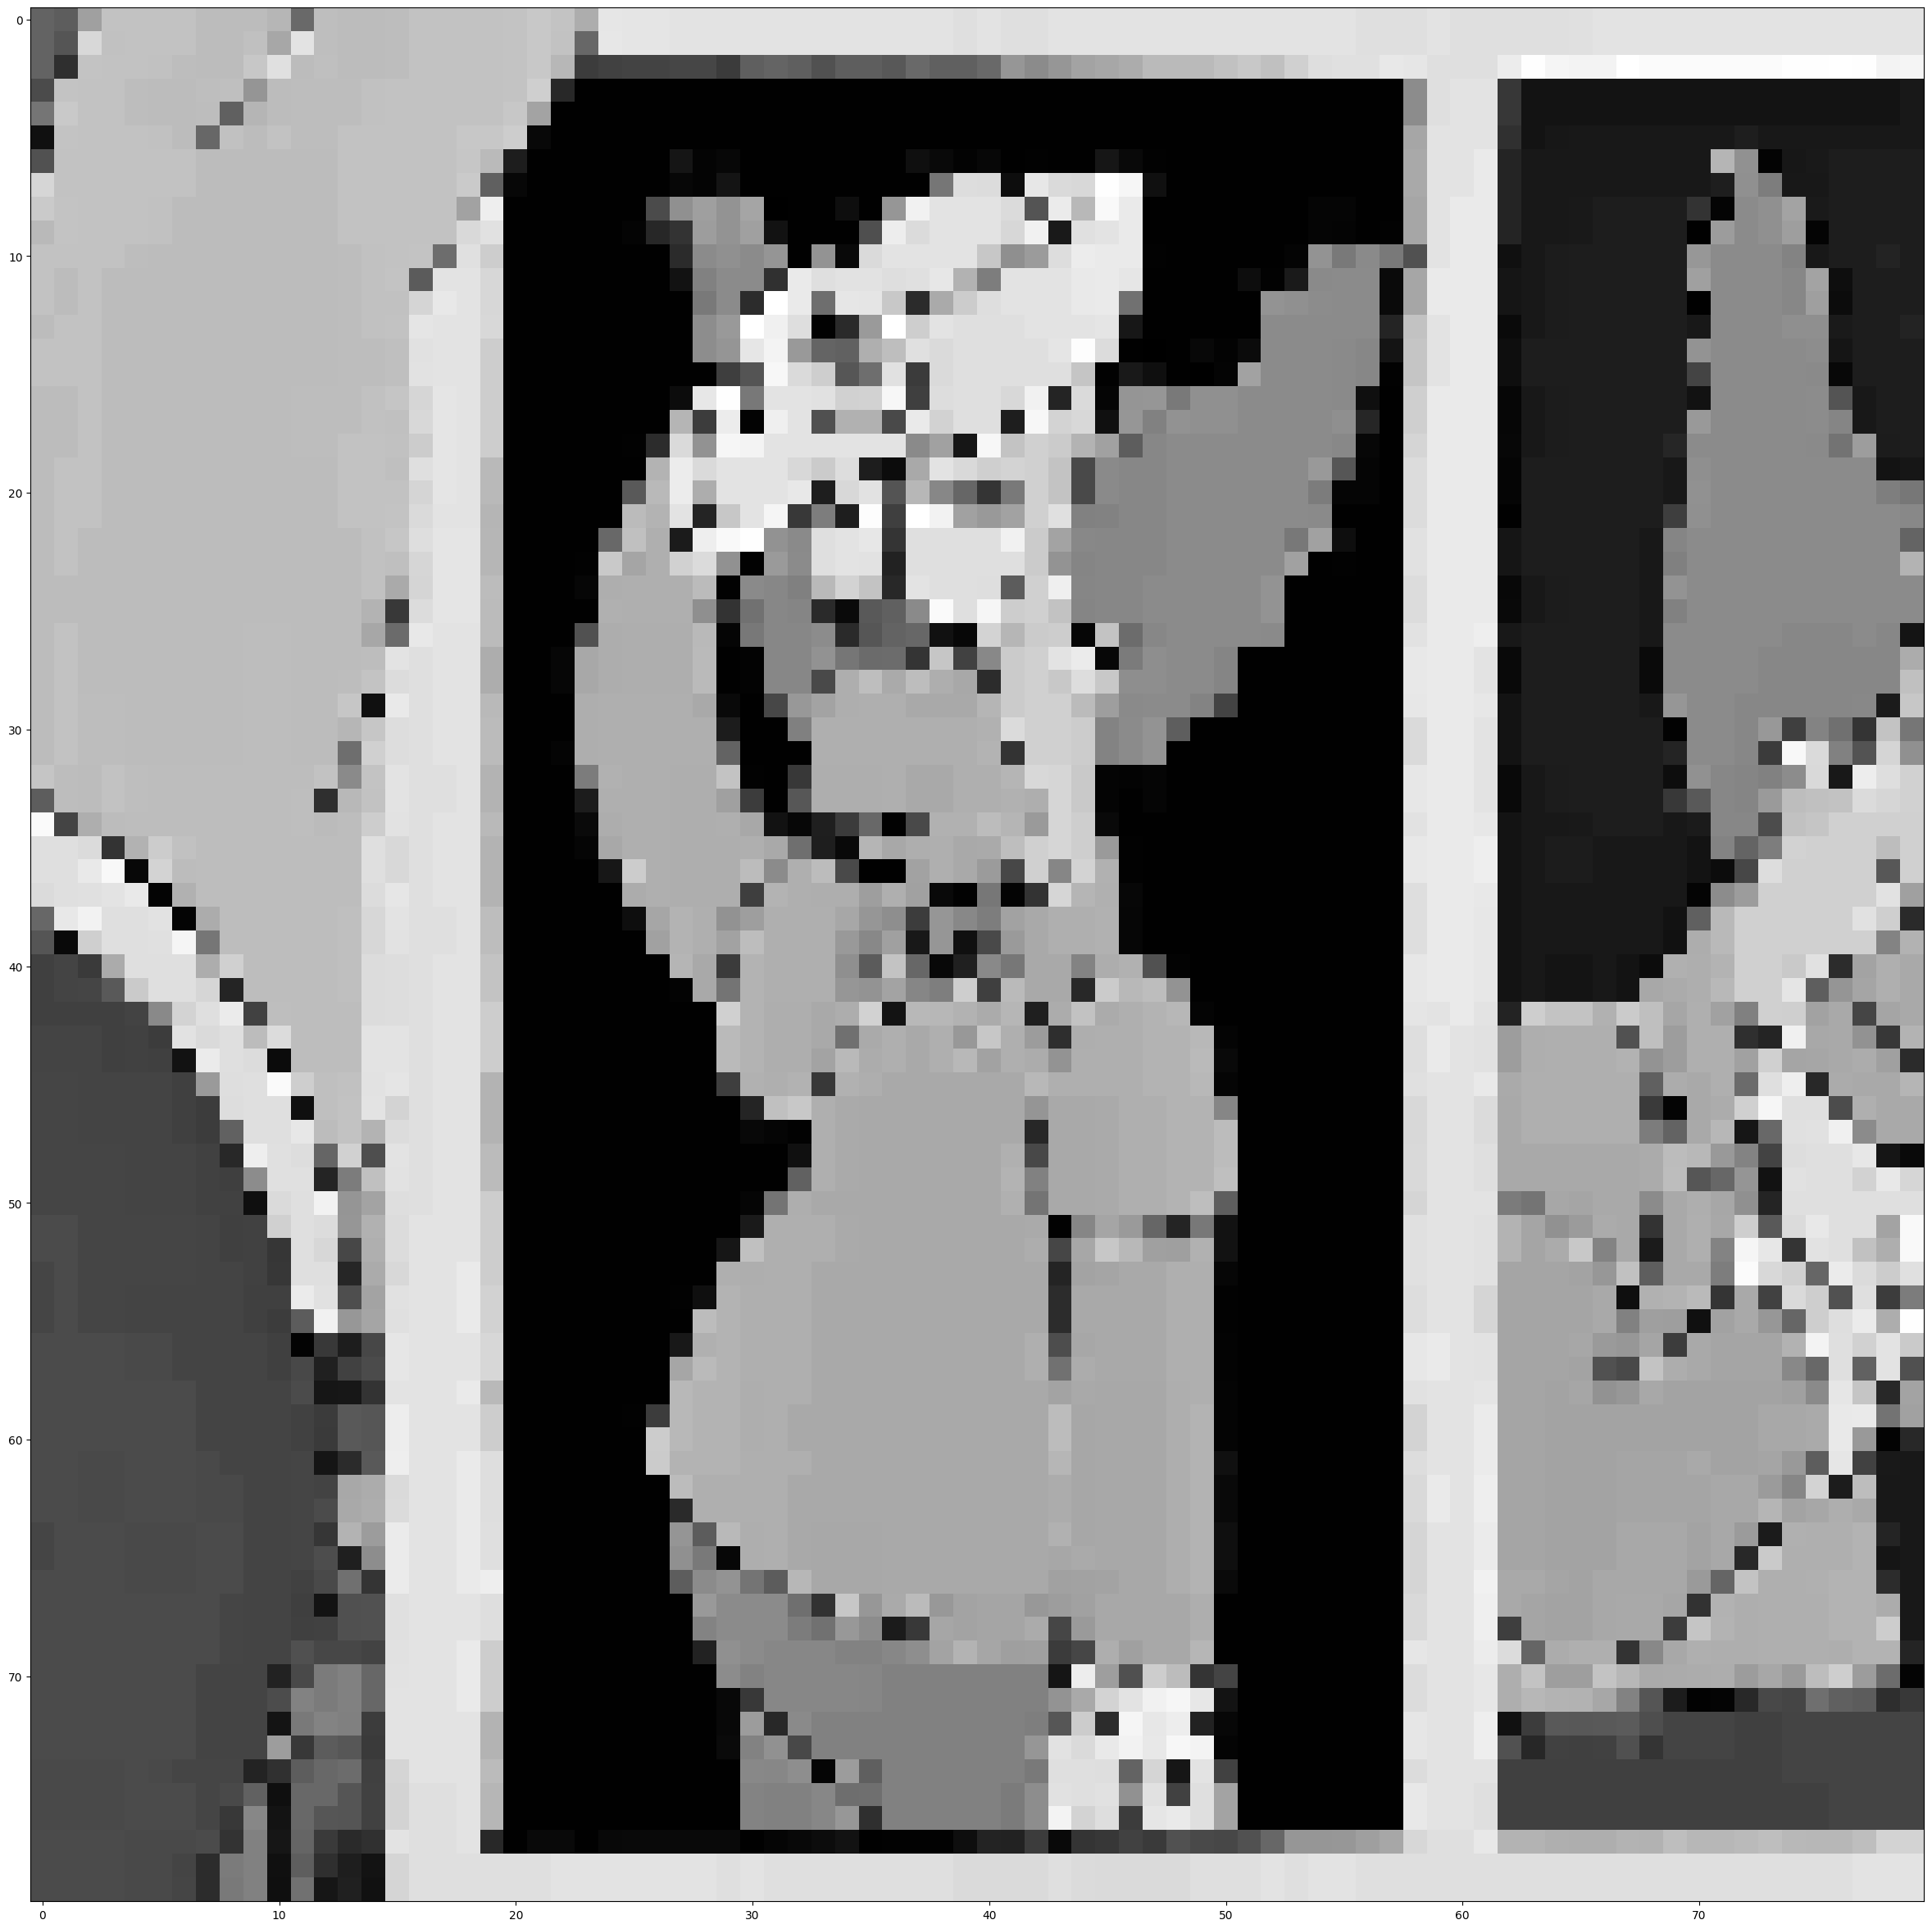

In [10]:
# visualizing
plt.figure(figsize=(30,30))
plt.imshow(train[0][0], cmap='gray')
plt.show()

In [11]:
# split to features and labels
featureSet, labels = caer.sep_train(train, IMG_SIZE=IMG_SIZE)

In [13]:
# Normalize the featureSet ===> (0,1)
featureSet = caer.normalize(featureSet)
labels = to_categorical(labels, len(characters))

In [14]:
# Create Train and Validation data 
x_train, x_val, y_train, y_val = caer.train_val_split(featureSet,labels ,val_ratio = .2 )

In [15]:
# Delete unimportant things
del train
del featureSet
del labels 
gc.collect()

1118

In [35]:
BATCH_SIZE = 32
EPOCHS = 128

In [20]:
# Imge data generator, It helps introduce some randomness into the network
datagen = ImageDataGenerator()
train_gen = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)

In [32]:
# Create a Sequential model
model = Sequential([
    Conv2D(32, (3, 3), input_shape=(80, 80, channels), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten the output before the dense layers
    Flatten(),

    # Add dense layers
    Dense(256, activation='relu'),
    Dense(len(characters), activation='softmax')
])

sgd_optimizer = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
# Compile the model
model.compile(optimizer=sgd_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 78, 78, 32)        320       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 39, 39, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 18, 18, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 8, 8, 128)        

In [33]:
# Call back for learning rate
callbacks_list = [LearningRateScheduler(canaro.lr_schedule)]

In [36]:
# Training model
training = model.fit(
    train_gen,
    steps_per_epoch=len(x_train) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    validation_steps=len(y_val) // BATCH_SIZE,
    callbacks=callbacks_list
)

Epoch 1/128
345/345 [==============================] - 2s 7ms/step - loss: 0.2382 - accuracy: 0.4823 - val_loss: 0.2533 - val_accuracy: 0.4399 - lr: 0.0100
Epoch 2/128
345/345 [==============================] - 2s 6ms/step - loss: 0.2280 - accuracy: 0.5197 - lr: 0.0100
Epoch 3/128
345/345 [==============================] - 2s 6ms/step - loss: 0.2168 - accuracy: 0.5547 - lr: 0.0100
Epoch 4/128
345/345 [==============================] - 2s 6ms/step - loss: 0.2046 - accuracy: 0.5867 - lr: 0.0100
Epoch 5/128
345/345 [==============================] - 2s 6ms/step - loss: 0.1912 - accuracy: 0.6194 - lr: 0.0100
Epoch 6/128
345/345 [==============================] - 2s 6ms/step - loss: 0.1764 - accuracy: 0.6624 - lr: 0.0100
Epoch 7/128
345/345 [==============================] - 2s 6ms/step - loss: 0.1617 - accuracy: 0.7039 - lr: 0.0100
Epoch 8/128
345/345 [==============================] - 2s 6ms/step - loss: 0.1451 - accuracy: 0.7388 - lr: 0.0100
Epoch 9/128
345/345 [=========================

In [37]:
characters

['homer_simpson',
 'ned_flanders',
 'moe_szyslak',
 'lisa_simpson',
 'bart_simpson',
 'marge_simpson',
 'krusty_the_clown',
 'principal_skinner',
 'charles_montgomery_burns',
 'milhouse_van_houten']

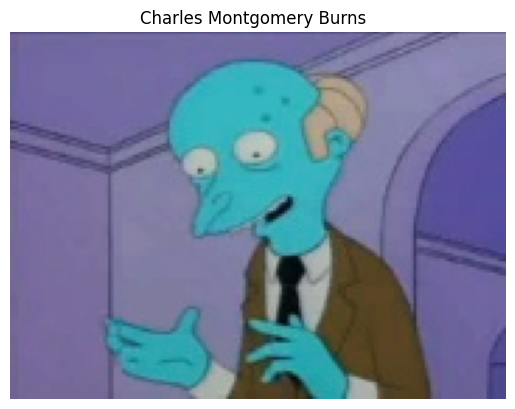

In [65]:
# test_path = r'/kaggle/input/the-simpsons-characters-dataset/kaggle_simpson_testset/kaggle_simpson_testset/bart_simpson_28.jpg'
test_path = r'/kaggle/input/the-simpsons-characters-dataset/kaggle_simpson_testset/kaggle_simpson_testset/charles_montgomery_burns_1.jpg'
img = cv.imread(test_path)

def format_image_title(file_path):
    # Extract the base name of the file without extension
    image_title = os.path.splitext(os.path.basename(file_path))[0]
    # Remove numbers and underscores using regular expression
    image_title = re.sub(r'[\d_]', ' ', image_title)
    # Capitalize the first character of each word
    formatted_title = image_title.title()
    
    return formatted_title

# Display the image using matplotlib
plt.imshow(img, cmap='gray')
plt.title(format_image_title(test_path))
plt.axis('off')  # Turn off axis labels
plt.show()

"""Create A function that makes the test image the same size, dimensions, 
   and color as the training image """
def prepare(img):
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img = cv.resize(img, IMG_SIZE)
    img = caer.reshape(img, IMG_SIZE, 1)
    return  img

In [58]:
# Predictions 
predictions = model.predict(prepare(img))

1/1 [==============================] - 0s 18ms/step


In [59]:
print(characters[np.argmax(predictions[0])])

charles_montgomery_burns
